# 應用 RFM 模式分析線上學習與學員分類

## 前言
[JoSeal](https://www.joseal.app) 是一個線上學習平台，在其中一個學習社群中，共有近百位學員上限觀看教學影片。我們透過行銷常用的 RFM 模式進行分析，其中 R(新近度)和 F(頻率)與一般模型的定義相同，而 M 則由銷售金額(Monertay) 調整為觀看影片的累積長度(Minutes)，藉由 RFM 三者的分數，將學員做分類，以利社群管理者做進一步追蹤。

## 資料匯入與清理

將觀看數據的資料下載為 csv，匯入後、篩選 2024 年上傳的影片，得到資料樣本數 982 筆，其中有學員數 105 位，影片 16 部、平均長度 27.32 分鐘、片總長度: 437.14分鐘。
資料中包含以下欄位: 

- vc_updatedAt: 紀錄更新時間，用來計算新近度R
- classroomId: 每部影片獨立的 id，同一學員每次觀看一部影片會有一筆紀錄，若重複觀看會增加新的紀錄
- adjusted_learingTime: 調整的觀看時間，每筆以不超過影片長度兩倍為限，用來計算觀看長度M
- userId: 每位學員的獨立 ids

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sns.set(font=['sans-serif'])
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})

In [44]:
df1 = pd.read_csv('./data/viewclassrooms.csv',         
                 usecols=["userId", "classroomId", "vc_updatedAt", "duration_min", "adjusted_learingTime"],
                sep=',', encoding='utf-8', encoding_errors='replace') 
df1.head()

,duration_min,adjusted_learingTime,vc_updatedAt,userId,classroomId
0,23.95,47.90,2024/6/18,6655cb45fec526cda5fcf3c2,6604d3c1ddee7910a5c5a891
1,31.63,23.55,2024/6/18,665d5ce1fec526cda54bd437,6594fbf6f5a58117e8a53471
2,23.95,0.78,2024/6/18,6048416fd32a05de2483b165,6604d3c1ddee7910a5c5a891
3,23.95,27.67,2024/6/17,6655cb45fec526cda5fcf3c2,6604d3c1ddee7910a5c5a891
4,31.63,0.05,2024/6/17,664eebf5d29eee6e9e135aa6,6594fbf6f5a58117e8a53471


In [45]:
df2 = pd.read_csv('./data/classroom_basic.csv',
                  usecols=["classroomId", "createdAt", "isHidden"],
                  sep=',', encoding='utf-8', encoding_errors='replace') 

df2['createdAt'] = pd.to_datetime(df2['createdAt'], format='%Y/%m/%d, %H:%M')
df2 = df2[(df2['isHidden'] == False) & (df2['createdAt'].dt.year == 2024)]
df2.head()

,isHidden,classroomId,createdAt
0,False,6604d3c1ddee7910a5c5a891,2024-03-28 10:19:00
1,False,65c057aa25f1987ae38bf0b3,2024-02-05 11:36:00
2,False,65c0576f25f198bd5e8beef4,2024-02-05 11:35:00
3,False,6594fdbd503ddd4ebd73b423,2024-01-03 14:25:00
5,False,6594fbf6f5a58117e8a53471,2024-01-03 14:17:00


In [46]:
df = df1.merge(df2, on="classroomId")
df.head()

,duration_min,adjusted_learingTime,vc_updatedAt,userId,classroomId,isHidden,createdAt
0,23.95,47.90,2024/6/18,6655cb45fec526cda5fcf3c2,6604d3c1ddee7910a5c5a891,False,2024-03-28 10:19:00
1,31.63,23.55,2024/6/18,665d5ce1fec526cda54bd437,6594fbf6f5a58117e8a53471,False,2024-01-03 14:17:00
2,23.95,0.78,2024/6/18,6048416fd32a05de2483b165,6604d3c1ddee7910a5c5a891,False,2024-03-28 10:19:00
3,23.95,27.67,2024/6/17,6655cb45fec526cda5fcf3c2,6604d3c1ddee7910a5c5a891,False,2024-03-28 10:19:00
4,31.63,0.05,2024/6/17,664eebf5d29eee6e9e135aa6,6594fbf6f5a58117e8a53471,False,2024-01-03 14:17:00


In [47]:
df.shape

(1023, 7)

In [48]:
df.isna().sum()

duration_min            0
adjusted_learingTime    0
vc_updatedAt            0
userId                  0
classroomId             0
isHidden                0
createdAt               0
dtype: int64

In [49]:
df.drop_duplicates(subset=["userId", "classroomId", "vc_updatedAt", "adjusted_learingTime"], keep="first", inplace=True)
record_count = df.shape[0]
print(f'樣本數: {record_count}')

樣本數: 982


In [50]:
user_count = df.userId.nunique()
class_count = df.classroomId.nunique()
duration_avg = df.groupby('classroomId')['duration_min'].max().mean().round(2)
duration_sum = df.groupby('classroomId')['duration_min'].max().sum().round(2)

print(f'學員數: {user_count}')
print(f'影片數: {class_count}')
print(f'影片平均長度: {duration_avg} mins')
print(f'影片總長度: {duration_sum} mins')

學員數: 105
影片數: 16
影片平均長度: 27.32 mins
影片總長度: 437.14 mins


## 資料分析與視覺化

- 分別計算 RFM，合成 rfm_df 資料表

In [51]:
import datetime as dt
df['date'] = pd.DatetimeIndex(df['vc_updatedAt']).date
now = df['date'].max()
print(f'樣本最後日期: {now}')

樣本最後日期: 2024-06-18


In [52]:
# 計算每個學員距離最後一次觀看紀錄多少天、作為新近度 R

recency_df = df.groupby(by='userId', as_index=False)['date'].max()
recency_df.columns = ['userId','lastWatchDate']
recency_df['recency'] = recency_df['lastWatchDate'].apply(lambda x: (now - x).days)
recency_df.head()

,userId,lastWatchDate,recency
0,6048416fd32a05de2483b165,2024-06-18,0
1,60508a2753b9b8cd7a54205a,2024-06-12,6
2,6090c48c993f2576455680bb,2024-04-19,60
3,6090cc8e0e92387513ecc459,2024-01-30,140
4,626b4f49b9fc23ba6141efc7,2024-05-28,21


In [53]:
recency_df.drop('lastWatchDate',axis=1,inplace=True)

In [54]:
# 計算每個學員的數據筆數、作為頻率 F
frequency_df = df.groupby(by=['userId'], as_index=False)['classroomId'].count()
frequency_df.columns = ['userId','frequency']
frequency_df.head()

,userId,frequency
0,6048416fd32a05de2483b165,82
1,60508a2753b9b8cd7a54205a,16
2,6090c48c993f2576455680bb,6
3,6090cc8e0e92387513ecc459,13
4,626b4f49b9fc23ba6141efc7,41


In [55]:
# 計算每個學員所有觀看的總時長、作為觀看時長 M

minute_df = df.groupby(by='userId',as_index=False).agg({'adjusted_learingTime': 'sum'})
minute_df.columns = ['userId','minutes']
minute_df.head()

,userId,minutes
0,6048416fd32a05de2483b165,369.455
1,60508a2753b9b8cd7a54205a,493.450
2,6090c48c993f2576455680bb,51.930
3,6090cc8e0e92387513ecc459,368.867
4,626b4f49b9fc23ba6141efc7,897.816


In [56]:
# 將資料合併為一個表格

rfm_df = recency_df.merge(frequency_df,on='userId').merge(minute_df,on='userId')
rfm_df.set_index('userId',inplace=True)
rfm_df.head()

,recency,frequency,minutes
userId,,,
6048416fd32a05de2483b165,0,82,369.455
60508a2753b9b8cd7a54205a,6,16,493.450
6090c48c993f2576455680bb,60,6,51.930
6090cc8e0e92387513ecc459,140,13,368.867
626b4f49b9fc23ba6141efc7,21,41,897.816


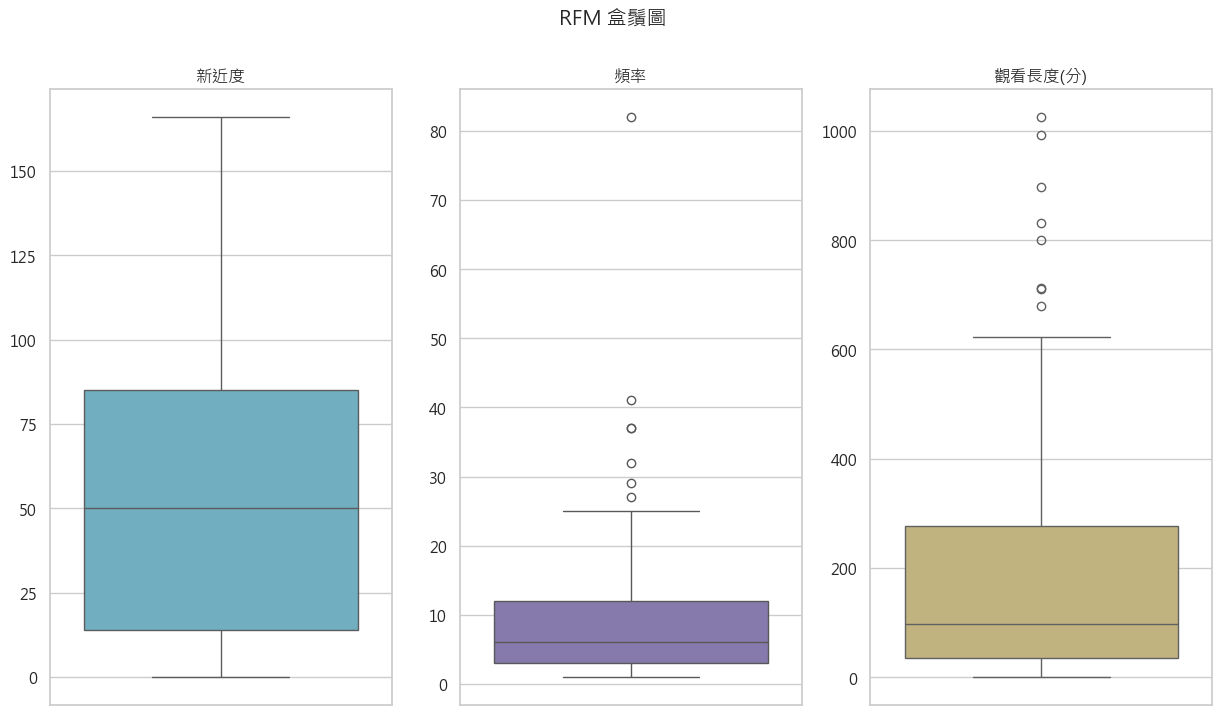

In [57]:
# 以盒鬚圖查看資料分布狀況

plt.figure(figsize=(15,8))

plt.subplot(1, 3, 1)
p1 = sns.boxplot(data=rfm_df, y="recency", color="c")
p1.set(ylabel = None)
plt.title("新近度")

plt.subplot(1, 3, 2)
p2 = sns.boxplot(data=rfm_df, y="frequency", color="m")
p2.set(ylabel = None)
plt.title("頻率")

plt.subplot(1, 3, 3)
p3 = sns.boxplot(data=rfm_df, y="minutes",  color="y")
p3.set(ylabel = None)
plt.title("觀看長度(分)")

plt.suptitle('RFM 盒鬚圖')
plt.show()

<Axes: xlabel='frequency', ylabel='users_count'>

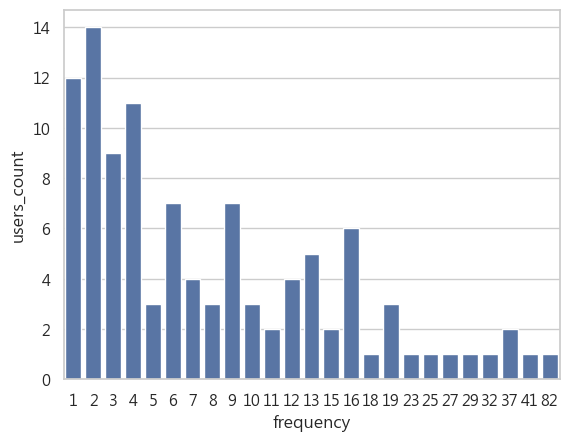

In [58]:
# 頻率的分布圖、82次的是社群管理者
frequency_df = rfm_df.groupby('frequency').size().reset_index(name='users_count')
sns.barplot(data=frequency_df, x="frequency", y='users_count')

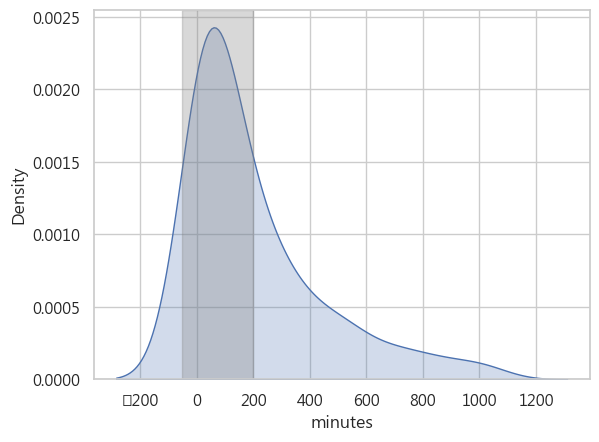

In [59]:
# 以密度圖表示
minutes_df = rfm_df.groupby('minutes').size().reset_index(name='users_count')
sns.kdeplot(data=rfm_df, x="minutes", shade=True)
plt.axvspan(-50, 200, color='gray', alpha=0.3)

In [60]:
min_mins = rfm_df.minutes.min()
max_mins = rfm_df.minutes.max()
print(f'觀看時長最短為 {min_mins}、最長為 {max_mins}')

觀看時長最短為 0.116、最長為 1025.302


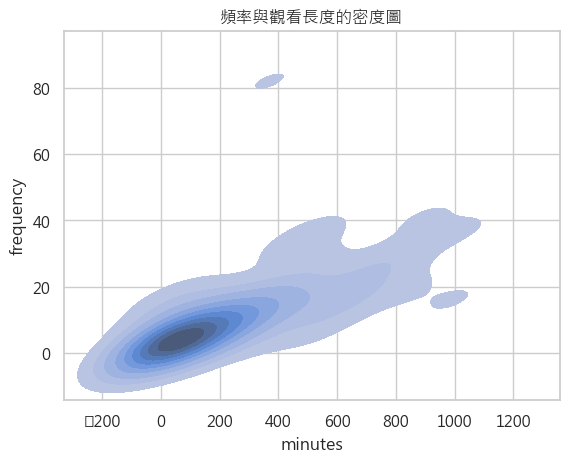

In [61]:
sns.kdeplot(data=rfm_df, x="minutes", y="frequency", shade=True)

plt.title('頻率與觀看長度的密度圖')
plt.show()

# RFM 模式分析

RFM 的分數設為 1 到 3 分，分數愈高代表正向，例如 r_score = 3 表示該名學員近期有線上學習，若 r_score = 1 則代表該名學員很久沒上線。

In [62]:
quantiles = rfm_df.quantile(q=[0.33,0.67])
quantiles

,recency,frequency,minutes
0.33,19.00,3.32,52.33840
0.67,77.68,9.68,218.62752


In [63]:
quantiles.to_dict()

{'recency': {0.33: 19.0, 0.67: 77.68},
 'frequency': {0.33: 3.3200000000000003, 0.67: 9.680000000000007},
 'minutes': {0.33: 52.3384, 0.67: 218.62752000000006}}

In [64]:
# 親近度愈近分數愈高、即 R 愈小的分數愈高
def RScore(x,p,d):
    if x <= d[p][0.33]:
        return 3
    elif x <= d[p][0.67]:
        return 2
    else:
        return 1
        
# 頻率和觀看時長則是愈大的分數愈高
def FMScore(x,p,d):
    if x <= d[p][0.33]:
        return 1
    elif x <= d[p][0.67]:
        return 2
    else:
        return 3

In [65]:
# 套用上述分類、將三個分數加到表格中

rfm_seg = rfm_df
rfm_seg['r_score'] = rfm_seg['recency'].apply(RScore, args=('recency',quantiles,))
rfm_seg['f_score'] = rfm_seg['frequency'].apply(FMScore, args=('frequency',quantiles,))
rfm_seg['m_score'] = rfm_seg['minutes'].apply(FMScore, args=('minutes',quantiles,))
rfm_seg.head()

,recency,frequency,minutes,r_score,f_score,m_score
userId,,,,,,
6048416fd32a05de2483b165,0,82,369.455,3,3,3
60508a2753b9b8cd7a54205a,6,16,493.450,3,3,3
6090c48c993f2576455680bb,60,6,51.930,2,2,1
6090cc8e0e92387513ecc459,140,13,368.867,1,3,3
626b4f49b9fc23ba6141efc7,21,41,897.816,2,3,3


In [66]:
# 將三個分數結合成一個欄位、方便後續比對 
rfm_seg['rfm_score'] = rfm_seg.r_score.map(str)  + rfm_seg.f_score.map(str)  + rfm_seg.m_score.map(str)
rfm_seg.head()

,recency,frequency,minutes,r_score,f_score,m_score,rfm_score
userId,,,,,,,
6048416fd32a05de2483b165,0,82,369.455,3,3,3,333
60508a2753b9b8cd7a54205a,6,16,493.450,3,3,3,333
6090c48c993f2576455680bb,60,6,51.930,2,2,1,221
6090cc8e0e92387513ecc459,140,13,368.867,1,3,3,133
626b4f49b9fc23ba6141efc7,21,41,897.816,2,3,3,233


In [67]:
# 找出三個分數都是最高的學員
rfm_seg[rfm_seg['rfm_score']=='333'].sort_values('minutes', ascending=False).head()

,recency,frequency,minutes,r_score,f_score,m_score,rfm_score
userId,,,,,,,
66043c9eddee7910a5bd8b8f,14,37,1025.302,3,3,3,333
6634993956f3fb993d48a8e6,19,16,992.320,3,3,3,333
665d5ce1fec526cda54bd437,0,19,831.227,3,3,3,333
6634792e56f3fb993d475792,14,29,799.230,3,3,3,333
663f77f1d7b168e84fa352b1,14,25,709.543,3,3,3,333


In [68]:
# 找出三個分數都是最低的學員
rfm_seg[rfm_seg['rfm_score']=='111'].sort_values('minutes', ascending=False).head()

,recency,frequency,minutes,r_score,f_score,m_score,rfm_score
userId,,,,,,,
6607d94bddee7910a5dfc002,80,1,34.53,1,1,1,111
65eecc619db5aec705b15e99,99,1,11.73,1,1,1,111
6607dfa3b2c5b35d01751778,80,2,9.55,1,1,1,111
65f3e6d8b724139eb8c48191,95,1,7.78,1,1,1,111
659f4c21503ddd1c7fc0801e,146,3,2.16,1,1,1,111


In [69]:
# 找出頻率很高、但較久沒有上線的學員
rfm_seg[(rfm_seg['r_score']==1) & (rfm_seg['f_score']==3)]

,recency,frequency,minutes,r_score,f_score,m_score,rfm_score
userId,,,,,,,
6090cc8e0e92387513ecc459,140,13,368.867,1,3,3,133
65a79608f70bcc6f5aabc0a5,137,19,679.960,1,3,3,133
65dadac135e6951e829a1973,113,10,249.144,1,3,3,133
65e32e05db499cb1c5747b32,107,10,102.890,1,3,2,132


In [70]:
# 進一步分析新近度和頻率、以熱力圖表示
rf_group = rfm_df.groupby(['r_score', 'f_score']).size().reset_index(name='users_count')
total_users = rfm_df.shape[0]
rf_group['% of users'] = (rf_group['users_count'] / total_users) * 100
rf_group

,r_score,f_score,users_count,% of users
0,1,1,18,17.142857
1,1,2,13,12.380952
2,1,3,4,3.809524
3,2,1,11,10.476190
4,2,2,12,11.428571
5,2,3,11,10.476190
6,3,1,6,5.714286
7,3,2,10,9.523810
8,3,3,20,19.047619


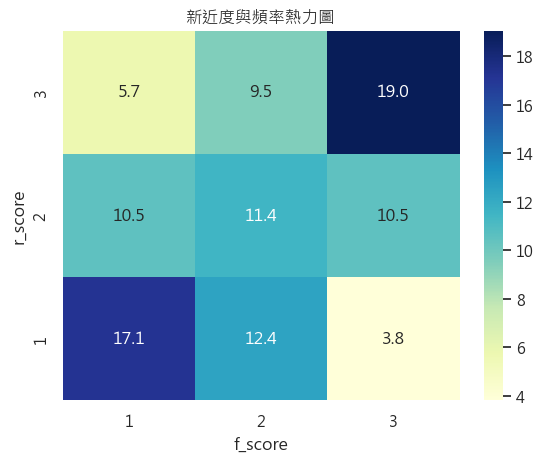

In [71]:
heatmap_df = pd.pivot_table(rf_group, index='r_score', columns='f_score', values='% of users')
heatmap_df = heatmap_df.reindex(sorted(heatmap_df.index, reverse=True))

sns.heatmap(heatmap_df, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('新近度與頻率熱力圖')
plt.show()

從熱力圖可以發現，頻率低近期低(17.1%)，和頻率高近期高(19.0%)的用戶占比較多，而兩者相斥的佔比較少。

前面我們將三項分數分開比較，接著我們將它們加總，最高 9 分(RFM皆為3)、最低 3 分(RFM皆為1分)並定義以下分類:
- 活躍學員（9分）: 這些學習者在最近的時間段內經常參與線上學習，並且花費相當多的時間學習。他們通常對於學習充滿熱情並且有強烈的學習動機。
- 潛在學員（7~8分）: 在過去的一段時間內參與過線上學習，參與頻率或觀看時間在中間。這些學習者可能已得到他們需要的知識，可以持續觀察。
- 須關注學員（5~6分）: 這些學員可能剛上線、需要更多的指導和支持來幫助他們進入線上學習環境。或是學習成效不如預期，需要更多的鼓勵和支持來提高他們的互動。
- 不活躍學員（3~4分）: 這些學員已經很長一段時間沒有參與線上學習了，或者他們只是偶爾參與。可能需要再次激發他們的學習興趣和動機。

In [72]:
# 將三項份數加總
rfm_unique = rfm_seg.groupby('rfm_score')['rfm_score'].nunique()
rfm_seg['rfm_sum'] = rfm_seg[['r_score','f_score','m_score']].sum(axis=1)
print(rfm_seg['rfm_sum'].head())

userId
6048416fd32a05de2483b165    9
60508a2753b9b8cd7a54205a    9
6090c48c993f2576455680bb    5
6090cc8e0e92387513ecc459    7
626b4f49b9fc23ba6141efc7    8
Name: rfm_sum, dtype: int64


In [73]:
# 依總分作分類
def rfm_level(df):
    if df['rfm_sum'] == 9:
        return 'Active'
    elif ((df['rfm_sum'] >= 7) and (df['rfm_sum'] < 9)):
        return 'Potential'
    elif ((df['rfm_sum'] >= 5) and (df['rfm_sum'] < 7)):
        return 'Attention-Required'
    else:
        return 'Inactive'

rfm_seg['rfm_level'] = rfm_seg.apply(rfm_level, axis=1)
rfm_seg.head()

,recency,frequency,minutes,r_score,f_score,m_score,rfm_score,rfm_sum,rfm_level
userId,,,,,,,,,
6048416fd32a05de2483b165,0,82,369.455,3,3,3,333,9,Active
60508a2753b9b8cd7a54205a,6,16,493.450,3,3,3,333,9,Active
6090c48c993f2576455680bb,60,6,51.930,2,2,1,221,5,Attention-Required
6090cc8e0e92387513ecc459,140,13,368.867,1,3,3,133,7,Potential
626b4f49b9fc23ba6141efc7,21,41,897.816,2,3,3,233,8,Potential


In [74]:
# 計算每個分類的平均值與個數
rfm_agg = rfm_seg.groupby('rfm_level').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'minutes': ['mean', 'count']
}).round(2)
print(rfm_agg)

                   recency frequency minutes      
                      mean      mean    mean count
rfm_level                                         
Active                8.00     23.29  539.99    17
Attention-Required   53.28      4.48   86.87    25
Inactive             95.27      2.70   26.66    33
Potential            38.60     12.83  300.87    30


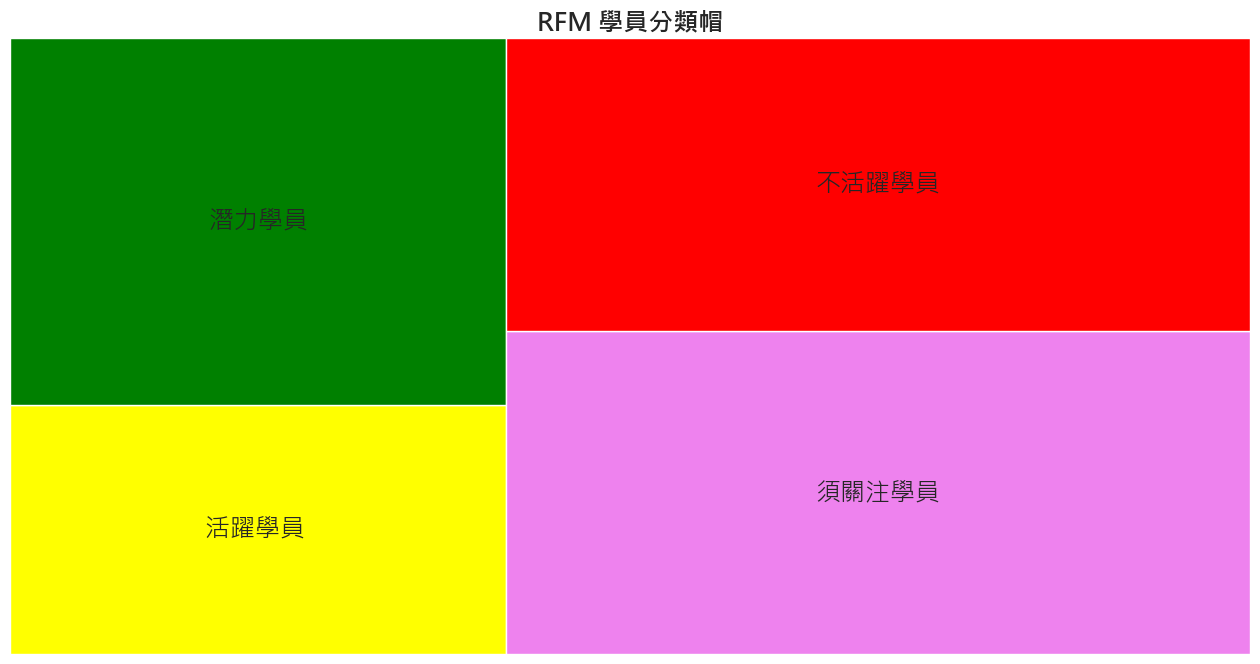

In [75]:
# 使用 squarify 套件來畫 RFM 模型常見的樹狀圖
import squarify

rfm_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 8)
squarify.plot(sizes=rfm_agg['Count'], 
              label=['活躍學員 ', '潛力學員', '須關注學員', '不活躍學員'], 
              color=["yellow", "green", "violet",  "red"],
              text_kwargs={'fontsize':18})
plt.title("RFM 學員分類帽", fontsize=18, fontweight="bold")
plt.axis('off')
plt.show()

RFM analysis reference:

- https://www.kaggle.com/code/sarahm/customer-segmentation-using-rfm-analysis
- https://joaocorreia.io/blog/rfm-analysis-increase-sales-by-segmenting-your-customers.html
- https://medium.com/analytics-vidhya/data-visualization-and-rfm-recency-frequency-and-monetary-analysis-using-python-customer-d7e129437aac